## Section 1 

In [1]:
# Initial imports and setup
import datetime as dt
import sys
import warnings
from datetime import datetime, timedelta
from time import time

import datacube
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
from datacube.testutils.io import rio_slurp_xarray
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
from datacube.utils.masking import mask_invalid_data
from dea_tools.landcover import lc_colourmap, make_colorbar, plot_land_cover
from dea_tools.plotting import display_map, rgb
from ipyleaflet import DrawControl, LayersControl, Map, WidgetControl, basemaps
from IPython.display import HTML, display
from ipywidgets import Dropdown, HBox, Output, VBox, interact, Button, FloatText, widgets
from pyproj import Proj, transform
from shapely.geometry import Polygon
from shapely.geometry.polygon import LinearRing
import os

warnings.filterwarnings("ignore")

# Setup paths and Datacube instance
current_dir = os.getcwd()
tools_path = os.path.join(current_dir, "Tools")
working_path = os.path.join(current_dir, "Working")

sys.path.insert(1, tools_path)
sys.path.insert(1, working_path)
dc = datacube.Datacube()

# Ensure openpyxl is installed
!pip install openpyxl

time_range = None

# Check if display_tools.py exists in Tools
if os.path.exists(tools_path):
    if "display_tools.py" in os.listdir(tools_path):
        try:
            from display_tools import display_da
            print("display_tools module imported successfully from Tools.")
        except ImportError as e:
            print(f"Error importing display_tools from Tools: {e}")
else:
    print(f"{tools_path} does not exist.")

# Check if display_tools.py exists in Working
if os.path.exists(working_path):
    if "display_tools.py" in os.listdir(working_path):
        try:
            from display_tools import display_da
            print("display_tools module imported successfully from Working.")
        except ImportError as e:
            print(f"Error importing display_tools from Working: {e}")
else:
    print(f"{working_path} does not exist.")

# Check if landcover.py exists in Working
if os.path.exists(working_path):
    if "landcover.py" in os.listdir(working_path):
        try:
            from landcover import lc_colourmap, make_colorbar, plot_land_cover
            print("landcover module imported successfully from Working.")
        except ImportError as e:
            print(f"Error importing landcover from Working: {e}")
else:
    print(f"{working_path} does not exist.")

# List files in Tools and Working
print(f"Files in {tools_path}:")
print(os.listdir(tools_path) if os.path.exists(tools_path) else f"{tools_path} does not exist.")
print(f"Files in {working_path}:")
print(os.listdir(working_path) if os.path.exists(working_path) else f"{working_path} does not exist.")


/home/jovyan/Living_Coasts_training/Tools does not exist.
/home/jovyan/Living_Coasts_training/Working does not exist.
/home/jovyan/Living_Coasts_training/Working does not exist.
Files in /home/jovyan/Living_Coasts_training/Tools:
/home/jovyan/Living_Coasts_training/Tools does not exist.
Files in /home/jovyan/Living_Coasts_training/Working:
/home/jovyan/Living_Coasts_training/Working does not exist.


## Section 2 

In [2]:
from ipyleaflet import Map, DrawControl, WidgetControl, basemaps, LayersControl, FullScreenControl, Rectangle
from ipywidgets import Output, Button, VBox, Tab, FloatText, Layout
from shapely.geometry import Polygon

# Initialize global variables to store the selected polygon
selected_polygon = None
manual_polygon_layer = None

# Define lat_range and lon_range to avoid NameError in Section 5
lat_range = None
lon_range = None

# Create the map
m = Map(center=[0, 0], zoom=2, basemap=basemaps.Esri.WorldImagery, scroll_wheel_zoom=True, layout=Layout(height='600px'))
m.add_control(LayersControl(position='topright'))
m.add_control(FullScreenControl())

# Output widget to display coordinates
output = Output(layout={'border': '1px solid black', 'padding': '5px'})

# Setup the draw control with both polygon and rectangle options
draw_control = DrawControl(
    rectangle={"shapeOptions": {"color": "#0000FF"}},
    polygon={"shapeOptions": {"color": "#00FF00"}},
    circlemarker={},
    polyline={},
    circle={}
)
m.add_control(draw_control)

# Event handler for drawing shapes
def handle_draw(target, action, geo_json):
    global selected_polygon, lat_range, lon_range
    output.clear_output()
    coords = geo_json['geometry']['coordinates'][0]
    selected_polygon = Polygon(coords)
    # Ensure consistent ordering of coordinates (assuming lon-lat order)
    lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
    lat_range = (min(lats), max(lats))
    lon_range = (min(lons), max(lons))
    with output:
        output.append_stdout("Coordinates:\n")
        output.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
        for lat, lon in zip(lats, lons):
            output.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")

draw_control.on_draw(handle_draw)

# Button to clear drawings and output
clear_button_draw = Button(description='Clear All')
clear_button_manual = Button(description='Clear All')

# Event handler for the clear button
def clear_all(b):
    global selected_polygon, manual_polygon_layer, lat_range, lon_range
    draw_control.clear()
    output.clear_output()
    if manual_polygon_layer:
        m.remove_layer(manual_polygon_layer)
    selected_polygon = None
    manual_polygon_layer = None
    lat_range = None
    lon_range = None

clear_button_draw.on_click(clear_all)
clear_button_manual.on_click(clear_all)

# Create input widgets for manual coordinate entry
latitude = FloatText(description='Latitude:', layout=Layout(width='100%'))
longitude = FloatText(description='Longitude:', layout=Layout(width='100%'))
buffer = FloatText(description='Buffer (deg):', value=0.1, layout=Layout(width='100%'))
update_button = Button(description='Update Map')

# Function to update the map based on manual input values
def update_map_manual(b):
    global manual_polygon_layer, selected_polygon, lat_range, lon_range
    output.clear_output()
    lat = latitude.value
    lon = longitude.value
    buf = buffer.value
    
    if lat is not None and lon is not None and buf is not None:
        bounds = [[lat - buf, lon - buf], [lat + buf, lon + buf]]
        if manual_polygon_layer:
            m.remove_layer(manual_polygon_layer)
        manual_polygon_layer = Rectangle(bounds=bounds, color="blue", fill_opacity=0.2, weight=2)
        m.add_layer(manual_polygon_layer)
        m.fit_bounds(bounds)
        
        selected_polygon = Polygon([(lon - buf, lat - buf), (lon + buf, lat - buf), (lon + buf, lat + buf), (lon - buf, lat + buf), (lon - buf, lat - buf)])
        lat_range = (lat - buf, lat + buf)
        lon_range = (lon - buf, lon + buf)
        
        with output:
            output.append_stdout("Manual Coordinates:\n")
            output.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            output.append_stdout(f"{lat - buf:.6f}\t\t{lon - buf:.6f}\n")
            output.append_stdout(f"{lat - buf:.6f}\t\t{lon + buf:.6f}\n")
            output.append_stdout(f"{lat + buf:.6f}\t\t{lon + buf:.6f}\n")
            output.append_stdout(f"{lat + buf:.6f}\t\t{lon - buf:.6f}\n")
    else:
        with output:
            output.append_stdout("Please fill in all coordinate values.\n")

# Connect the manual update button
update_button.on_click(update_map_manual)

# Tab widget for drawing and manual input
draw_tab = VBox([clear_button_draw, output])
manual_tab = VBox([latitude, longitude, buffer, update_button, clear_button_manual, output])

tab = Tab()
tab.children = [draw_tab, manual_tab]
tab.set_title(0, 'Draw')
tab.set_title(1, 'Manual Input')

# Add the tab control to the map
tab_control = WidgetControl(widget=tab, position='topright')
m.add_control(tab_control)

# Display the map
display(m)



Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

## Section 3

The drawn shape was used for selection.
The geopolygon of interest is the following one; 
POLYGON ((153.093817 -24.829741, 153.093817 -24.652634, 153.310797 -24.652634, 153.310797 -24.829741, 153.093817 -24.829741))

Selected Polygon Coordinates:
Latitude: -24.829741, Longitude: 153.093817
Latitude: -24.652634, Longitude: 153.093817
Latitude: -24.652634, Longitude: 153.310797
Latitude: -24.829741, Longitude: 153.310797
Latitude: -24.829741, Longitude: 153.093817

UTM Coordinates:
UTM X: 4985298.411056648, UTM Y: -16464396.960821958
UTM X: 4994006.871677169, UTM Y: -16487507.304060396
UTM X: 4968129.385184013, UTM Y: -16497188.75872912
UTM X: 4959500.490832379, UTM Y: -16474113.374900963
UTM X: 4985298.411056648, UTM Y: -16464396.960821958


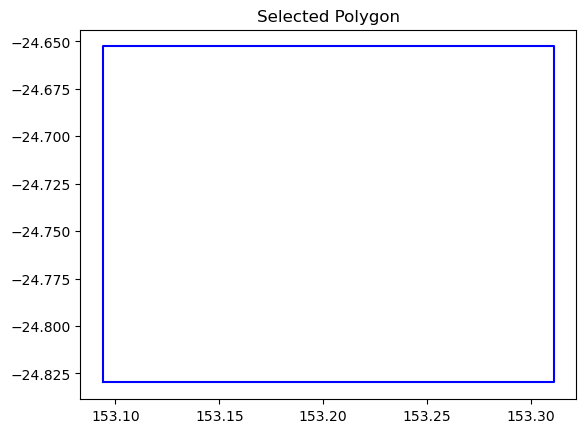

In [3]:
import matplotlib.pyplot as plt
from pyproj import Proj
from shapely.geometry.polygon import LinearRing

# Function to convert latitude and longitude to UTM coordinates
def latlon_to_utm(lat, lon):
    utm_proj = Proj(proj="utm", zone=33, datum="WGS84")  # Change zone as needed
    utm_x, utm_y = utm_proj(lon, lat)
    return utm_x, utm_y

# Function to display the selected coordinates, UTM coordinates, and visualize the polygon
def display_selected_coordinates(selected_polygon):
    if selected_polygon is not None:
        coords = selected_polygon.exterior.coords
        utm_coords = [latlon_to_utm(lat, lon) for lon, lat in coords]

        print("The drawn shape was used for selection.")
        print("The geopolygon of interest is the following one; ")
        print(selected_polygon)

        print("\nSelected Polygon Coordinates:")
        for lon, lat in coords:
            print(f"Latitude: {lat}, Longitude: {lon}")

        print("\nUTM Coordinates:")
        for utm_x, utm_y in utm_coords:
            print(f"UTM X: {utm_x}, UTM Y: {utm_y}")

        # Visualize the selected polygon
        ring = LinearRing(coords)
        fig, ax = plt.subplots()
        ax.plot(*ring.xy, color="blue")
        ax.set_title("Selected Polygon")
        plt.show()
    else:
        print("No polygon selected")

# Call the function to display the coordinates and visualize the polygon
# Assuming you have the selected polygon stored in a variable named 'selected_polygon'
display_selected_coordinates(selected_polygon)


## Section 4

In [4]:
from datetime import datetime
from IPython.display import display
from ipywidgets import widgets

# Input widgets for specifying the year range
start_date_input = widgets.DatePicker(
    description="Start Date", value=datetime(2010, 1, 1)  # Default value (example)
)

end_date_input = widgets.DatePicker(
    description="End Date", value=datetime(2020, 12, 31)  # Default value (example)
)

# Display date pickers
display(start_date_input, end_date_input)

# Update the global variables with the selected time range
def update_time_range(change):
    global time_range
    start_date = start_date_input.value
    end_date = end_date_input.value
    time_range = (start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
    print(f"Selected time range: {time_range}")

# Attach the update function to the date pickers
start_date_input.observe(update_time_range, names='value')
end_date_input.observe(update_time_range, names='value')

# Initial call to set the time range
update_time_range(None)


DatePicker(value=datetime.datetime(2010, 1, 1, 0, 0), description='Start Date', step=1)

DatePicker(value=datetime.datetime(2020, 12, 31, 0, 0), description='End Date', step=1)

Selected time range: ('2010-01-01', '2020-12-31')


## Section 5

In [5]:
# Section 5: Load Data from Datacube

# Step 1: Check if required variables are defined
if lat_range is None or lon_range is None or start_date_input.value is None or end_date_input.value is None:
    raise ValueError("Latitude, Longitude, or Time range is not defined")

print("Lat Range:", lat_range)
print("Lon Range:", lon_range)
print("Start Date:", start_date_input.value)
print("End Date:", end_date_input.value)

# Step 2: Construct the query
query = {
    "y": lat_range,
    "x": lon_range,
    "time": (start_date_input.value, end_date_input.value),
}

print("Query Parameters:", query)

# Step 3: Load DEA Land Cover data from the datacube
try:
    lc = dc.load(
        product="ga_ls_landcover_class_cyear_2",
        output_crs="EPSG:3577",
        measurements=[
            "level3",
            "lifeform",
            "vegetation_cover",
            "water_seasonality",
            "water_state",
            "intertidal",
            "water_persistence",
            "bare_gradation",
            "full_classification",
        ],
        resolution=(-25, 25),
        **query
    )
    print("Data loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading data from the datacube: {e}")

# Step 4: Check if the dataset is loaded correctly
if lc is None or lc.geobox is None:
    raise ValueError("Failed to load the dataset. Please check the query parameters and ensure data is available for the specified region and time range.")

# Step 5: Print geobox information
geobox = lc.geobox

geobox_info = f"""
Geobox Information:
-------------------
CRS: {geobox.crs}
Dimensions: {geobox.dimensions}
Resolution: {geobox.resolution}
Shape: {geobox.shape}
Extent: {geobox.extent}
"""

print(geobox_info)

# Step 6: Check loaded data dimensions and variables
print("Loaded data dimensions:", lc.dims)
print("Loaded data variables:", lc.data_vars)


Lat Range: (-24.829741, -24.652634)
Lon Range: (153.093817, 153.310797)
Start Date: 2010-01-01 00:00:00
End Date: 2020-12-31 00:00:00
Query Parameters: {'y': (-24.829741, -24.652634), 'x': (153.093817, 153.310797), 'time': (datetime.datetime(2010, 1, 1, 0, 0), datetime.datetime(2020, 12, 31, 0, 0))}
Data loaded successfully.

Geobox Information:
-------------------
CRS: PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS

In [6]:
# Section 5: Load Data from Datacube

# Ensure the required variables are defined
if lat_range is None or lon_range is None or start_date_input.value is None or end_date_input.value is None:
    raise ValueError("Latitude, Longitude, or Time range is not defined")

print("Lat Range:", lat_range)
print("Lon Range:", lon_range)
print("Start Date:", start_date_input.value)
print("End Date:", end_date_input.value)

# Construct the query
query = {
    "y": lat_range,
    "x": lon_range,
    "time": (start_date_input.value, end_date_input.value),
}

print("Query Parameters:", query)

# Load DEA Land Cover data from the datacube
try:
    lc = dc.load(
        product="ga_ls_landcover_class_cyear_2",
        output_crs="EPSG:3577",
        measurements=[
            "level3",
            "lifeform",
            "vegetation_cover",
            "water_seasonality",
            "water_state",
            "intertidal",
            "water_persistence",
            "bare_gradation",
            "full_classification",
        ],
        resolution=(-25, 25),
        **query
    )
except Exception as e:
    raise RuntimeError(f"Error loading data from the datacube: {e}")

# Check if the dataset is loaded correctly
if lc is None or lc.geobox is None:
    raise ValueError("Failed to load the dataset. Please check the query parameters and ensure data is available for the specified region and time range.")

# Print geobox information
geobox = lc.geobox

geobox_info = f"""
Geobox Information:
-------------------
CRS: {geobox.crs}
Dimensions: {geobox.dimensions}
Resolution: {geobox.resolution}
Shape: {geobox.shape}
Extent: {geobox.extent}
"""

print(geobox_info)

# Check loaded data dimensions and variables
print("Loaded data dimensions:", lc.dims)
print("Loaded data variables:", lc.data_vars)


Lat Range: (-24.829741, -24.652634)
Lon Range: (153.093817, 153.310797)
Start Date: 2010-01-01 00:00:00
End Date: 2020-12-31 00:00:00
Query Parameters: {'y': (-24.829741, -24.652634), 'x': (153.093817, 153.310797), 'time': (datetime.datetime(2010, 1, 1, 0, 0), datetime.datetime(2020, 12, 31, 0, 0))}

Geobox Information:
-------------------
CRS: PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORI

## Section 6

In [7]:
# Section 6: Checkbox widgets for selecting datasets
level3_checkbox = widgets.Checkbox(description='Level 3', value=False)
lifeform_checkbox = widgets.Checkbox(description='Lifeform', value=False)
vegetation_cover_checkbox = widgets.Checkbox(description='Vegetation Cover', value=False)
water_state_checkbox = widgets.Checkbox(description='Water State', value=False)
full_classification_checkbox = widgets.Checkbox(description='Full Classification', value=False)

output = widgets.Output()

def plot_selected_datasets():
    with output:
        output.clear_output()
        selected_datasets = []
        if level3_checkbox.value:
            selected_datasets.append('level3')
        if lifeform_checkbox.value:
            selected_datasets.append('lifeform')
        if vegetation_cover_checkbox.value:
            selected_datasets.append('vegetation_cover')
        if water_state_checkbox.value:
            selected_datasets.append('water_state')
        if full_classification_checkbox.value:
            selected_datasets.append('full_classification')

        for dataset in selected_datasets:
            plt.figure()
            if dataset == 'level3':
                plot_land_cover(lc.level3)
            elif dataset == 'lifeform':
                plot_land_cover(lc.lifeform)
            elif dataset == 'vegetation_cover':
                plot_land_cover(lc.vegetation_cover)
            elif dataset == 'water_state':
                plot_land_cover(lc.water_state)
            elif dataset == 'full_classification':
                plot_land_cover(lc.full_classification)
            plt.show()

plot_datasets_button = widgets.Button(description='Plot Selected Datasets')
plot_datasets_button.on_click(lambda b: plot_selected_datasets())

checkboxes_box = widgets.HBox([
    level3_checkbox, 
    lifeform_checkbox, 
    vegetation_cover_checkbox, 
    water_state_checkbox, 
    full_classification_checkbox
])
display(checkboxes_box)
display(plot_datasets_button)
display(output)


Button(description='Plot Selected Datasets', style=ButtonStyle())

Output()

## Section 7

In [8]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML

# Load the dataset from the specified relative path
file_path = './gct/Impacts and pressures.xlsx'
df = pd.read_excel(file_path)

# Replace NaN values in 'Impact_ID' and 'Pressure_ID' columns with zeros
df['Impact_ID'] = df['Impact_ID'].fillna(0)
df['Pressure_ID'] = df['Pressure_ID'].fillna(0)

# Make sure that the IDs are integers to avoid the decimal point in the display
df['Impact_ID'] = df['Impact_ID'].astype(int)
df['Pressure_ID'] = df['Pressure_ID'].astype(int)

# Map each impact with its ID to pressures with their IDs
impact_to_pressures = {
    f"{row['Impacts']} ({row['Impact_ID']})": df[
        (df['Impacts'] == row['Impacts']) & 
        (df['Impact_ID'] == row['Impact_ID'])
    ][['Pressures', 'Pressure_ID']].apply(
        lambda x: f"{x['Pressures']} ({x['Pressure_ID']})", axis=1).unique().tolist()
    for _, row in df.drop_duplicates(subset=['Impacts', 'Impact_ID']).iterrows()
}

# Create a dictionary to map each identifier to its associated evidence with values
identifier_to_evidence = {}

# Define evidence groups
time_columns = ['TimeO_Ev', 'TimeL_Ev', 'TimeM_Ev', 'TimeD_Ev', 'Space_Ev']
level3_columns = ['Level3a_Ev', 'Level3b_Ev', 'Level3c_Ev', 'Level3d_Ev', 'Level3e_Ev', 'Level3f_Ev', 'Level3g_Ev']
lifeform_columns = ['Lifeforma_Ev', 'Lifeformb_Ev', 'Lifeformc_Ev', 'Lifeformd_Ev']
water_columns = ['Waterpera_Ev', 'Waterperb_Ev', 'Waterperc_Ev', 'Waterperd_Ev', 'Waterpere_Ev', 'Waterperf_Ev']
biomass_columns = ['AGB_Ev', 'AGBSD_Ev']
individual_columns = ['Canopycoa_Ev', 'Fire presence', 'Turbidity']

# Function to clean and convert values to integers
def clean_value(value):
    try:
        return int(float(value))
    except (ValueError, TypeError):
        return None

for _, row in df.iterrows():
    identifier = row['Impact_ID'] * 1000 + row['Pressure_ID']
    
    evidence_with_values = {
        'IP_UID': row['IP_UID'],
        'ID_Colour': row['ID_Colour']
    }
    
    # Collect Time Evidence
    evidence_with_values['Time_Evidence'] = []
    for col in time_columns:
        value = clean_value(row[col])
        if value is not None:
            evidence_with_values['Time_Evidence'].append((col, value))
    
    # Collect Level3 Evidence
    evidence_with_values['Level3_Evidence'] = []
    for col in level3_columns:
        value = clean_value(row[col])
        if value is not None:
            evidence_with_values['Level3_Evidence'].append((col, value))
    
    # Collect Lifeform Evidence
    evidence_with_values['Lifeform_Evidence'] = []
    for col in lifeform_columns:
        value = clean_value(row[col])
        if value is not None:
            evidence_with_values['Lifeform_Evidence'].append((col, value))
    
    # Collect Water Evidence
    evidence_with_values['Water_Evidence'] = []
    for col in water_columns:
        value = clean_value(row[col])
        if value is not None:
            evidence_with_values['Water_Evidence'].append((col, value))
    
    # Collect Biomass Evidence
    evidence_with_values['Biomass_Evidence'] = []
    for col in biomass_columns:
        value = clean_value(row[col])
        if value is not None:
            evidence_with_values['Biomass_Evidence'].append((col, value))
    
    # Collect Individual Evidence
    evidence_with_values['Individual_Evidence'] = []
    for col in individual_columns:
        value = clean_value(row[col])
        if value is not None:
            evidence_with_values['Individual_Evidence'].append((col, value))
    
    identifier_to_evidence[identifier] = evidence_with_values

# Create the dropdown widgets for impacts and pressures with IDs
impact_dropdown = widgets.Dropdown(
    options=[(impact, impact) for impact in impact_to_pressures.keys()],
    description='Impact:',
    value=None  # Start without a selection
)

pressure_dropdown = widgets.Dropdown(
    options=[('Please select an Impact first', '')],
    description='Pressure:',
    value=None  # Start without a selection
)

# Define the output widget for displaying the calculation result and evidence
output = widgets.Output()

# Define the function to update pressure dropdown based on selected impact
def on_impact_change(change):
    if change['new']:
        selected_impact = change['new']
        pressures = impact_to_pressures.get(selected_impact, [])
        pressure_dropdown.options = [(p, p) for p in pressures]
    else:
        pressure_dropdown.options = [('Please select an Impact first', '')]

# Define the function to display the selected impact and pressure
def display_selection(impact, pressure):
    with output:
        output.clear_output()
        if impact and pressure:
            impact_id = int(impact.split('(')[1].split(')')[0])
            pressure_id = int(pressure.split('(')[1].split(')')[0])
            identifier = impact_id * 1000 + pressure_id

            display(HTML(f'<strong>Selected Impact:</strong> {impact}'))
            display(HTML(f'<strong>Selected Pressure:</strong> {pressure}'))
            display(HTML(f'<strong>Identifier:</strong> {identifier}'))
            
            if identifier in identifier_to_evidence:
                evidence = identifier_to_evidence[identifier]
                display(HTML(f'<strong>IP_UID:</strong> {evidence["IP_UID"]}'))
                display(HTML(f'<strong>ID_Colour:</strong> {evidence["ID_Colour"]}'))
                display(HTML('<strong>Evidence:</strong>'))
                for group, values in evidence.items():
                    if group not in ['IP_UID', 'ID_Colour'] and values:
                        display(HTML(f'<strong>{group.replace("_", " ")}:</strong>'))
                        for evidence_name, value in values:
                            display(HTML(f'- {evidence_name}: {value}'))
        elif impact:
            display(HTML(f'<strong>Selected Impact:</strong> {impact}'))
            display(HTML('<strong>Please select a pressure.</strong>'))
        else:
            display(HTML('<strong>Please select an impact.</strong>'))

# Set up observation for changes in the impact dropdown
impact_dropdown.observe(on_impact_change, names='value')

# Set up interaction to display selections
widgets.interactive(display_selection, impact=impact_dropdown, pressure=pressure_dropdown)

# Arrange the widgets and the output display
display(widgets.VBox([impact_dropdown, pressure_dropdown, output]))


## Section 8 

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Define evidence groups
time_columns = ['TimeO_Ev', 'TimeL_Ev', 'TimeM_Ev', 'TimeD_Ev', 'Space_Ev']
level3_columns = ['Level3a_Ev', 'Level3b_Ev', 'Level3c_Ev', 'Level3d_Ev', 'Level3e_Ev', 'Level3f_Ev', 'Level3g_Ev']
lifeform_columns = ['Lifeforma_Ev', 'Lifeformb_Ev', 'Lifeformc_Ev', 'Lifeformd_Ev']
water_columns = ['Waterpera_Ev', 'Waterperb_Ev', 'Waterperc_Ev', 'Waterperd_Ev', 'Waterpere_Ev', 'Waterperf_Ev']
biomass_columns = ['AGB_Ev', 'AGBSD_Ev']
individual_columns = ['Canopycoa_Ev', 'Fire presence', 'Turbidity']

# Function to extract evidence values from Section 7
def get_evidence_output():
    evidence_output = {}
    for col in level3_columns + lifeform_columns + water_columns + biomass_columns + individual_columns:
        evidence_output[col] = globals().get(col, None)
    return evidence_output

# Get the actual evidence output from Section 7
evidence_output = get_evidence_output()

# Ensure lc is defined (Section 5)
# Load data from the Datacube
try:
    lc = dc.load(
        product="ga_ls_landcover_class_cyear_2",
        output_crs="EPSG:3577",
        measurements=[
            "level3",
            "lifeform",
            "vegetation_cover",
            "water_seasonality",
            "water_state",
            "intertidal",
            "water_persistence",
            "bare_gradation",
            "full_classification",
        ],
        resolution=(-25, 25),
        **query
    )
except Exception as e:
    raise RuntimeError(f"Error loading data from the datacube: {e}")

# Load actual data for level3, lifeform, water persistence changes
start_l3 = lc.level3[0].astype(np.int32)
end_l3 = lc.level3[-1].astype(np.int32)
change_vals_l3 = (start_l3 * 1000) + end_l3

start_lf = lc.lifeform[0].astype(np.int32)
end_lf = lc.lifeform[-1].astype(np.int32)
change_vals_lf = (start_lf * 10) + end_lf

# Convert to datasets
obs_change_l3_2010_2020 = xr.DataArray(
    data=change_vals_l3,
    coords=lc.level3[0].coords,
    dims=lc.level3[0].dims,
    name="observed change",
    attrs=lc.level3[0].attrs,
    fastpath=False,
).to_dataset(name="l3_2010_2020")

obs_change_lf_2010_2020 = xr.DataArray(
    data=change_vals_lf,
    coords=lc.lifeform[0].coords,
    dims=lc.lifeform[0].dims,
    name="observed change",
    attrs=lc.lifeform[0].attrs,
    fastpath=False,
).to_dataset(name="lf_2010_2020")

# Define function to create and display individual masks
def create_and_display_individual_masks(evidence_output):
    for key, value in evidence_output.items():
        if value is None:
            continue

        if key.startswith('Level3'):
            change = np.where((obs_change_l3_2010_2020.l3_2010_2020 == value), 1, 0)
            change_xr = xr.DataArray(
                data=change,
                coords=obs_change_l3_2010_2020.coords,
                dims=obs_change_l3_2010_2020.dims,
                name="Change",
                attrs=None
            )
            change_ds = change_xr.to_dataset(name="Change")
            
            # Plot the results
            fig, ax = plt.subplots(figsize=(10, 6))
            change_ds.Change.plot(ax=ax, cmap='Reds')
            ax.set_title(f"Level3 Change Mask for {key} Value {value}")
            plt.show()
        
        elif key.startswith('Lifeform'):
            change = np.where((obs_change_lf_2010_2020.lf_2010_2020 == value), 1, 0)
            change_xr = xr.DataArray(
                data=change,
                coords=obs_change_lf_2010_2020.coords,
                dims=obs_change_lf_2010_2020.dims,
                name="Change",
                attrs=None
            )
            change_ds = change_xr.to_dataset(name="Change")
            
            # Plot the results
            fig, ax = plt.subplots(figsize=(10, 6))
            change_ds.Change.plot(ax=ax, cmap='Blues')
            ax.set_title(f"Lifeform Change Mask for {key} Value {value}")
            plt.show()

# Call the function to create and display the masks
create_and_display_individual_masks(evidence_output)


Selected Level3 Values: [111111, 112112]
Selected Lifeform Values: [10, 20, 12]


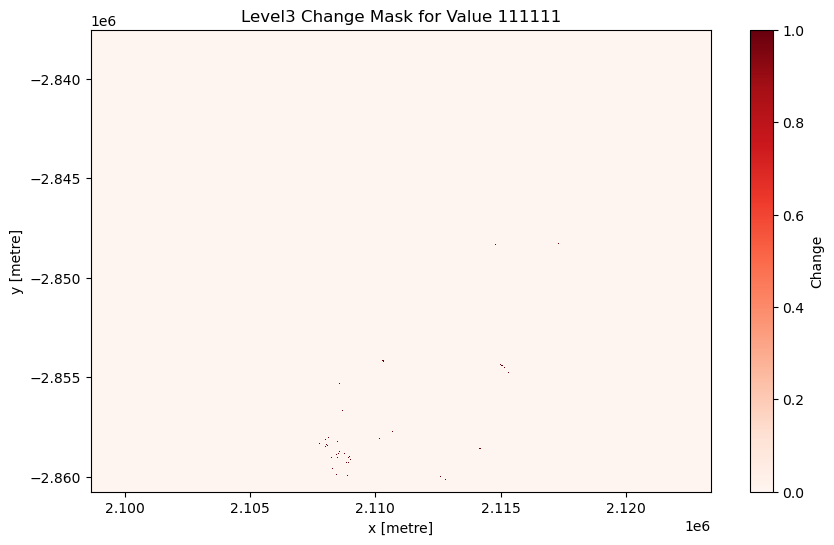

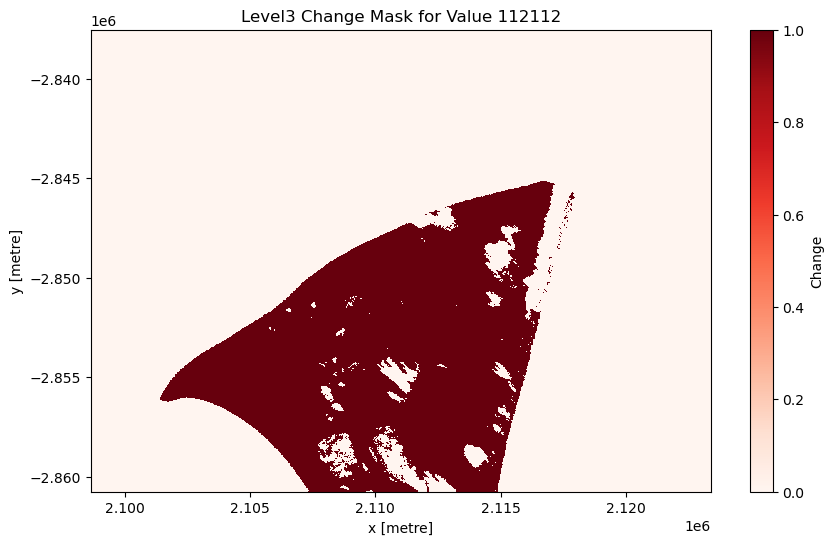

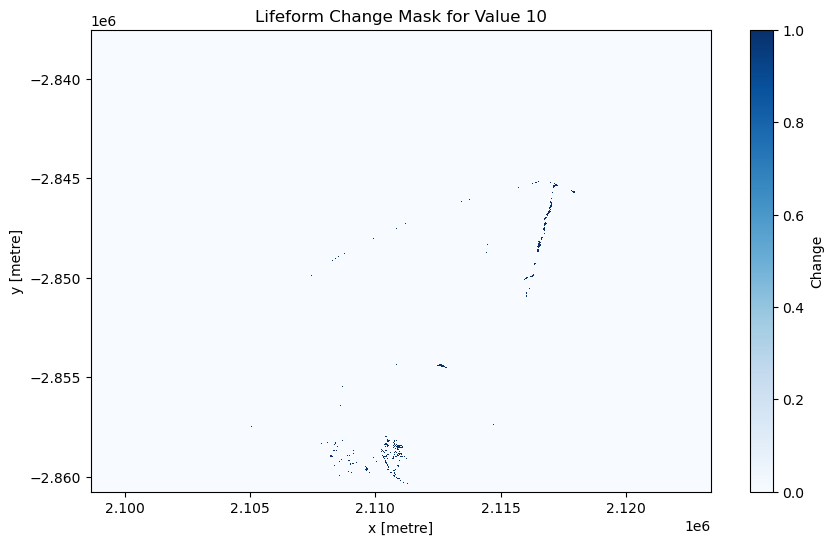

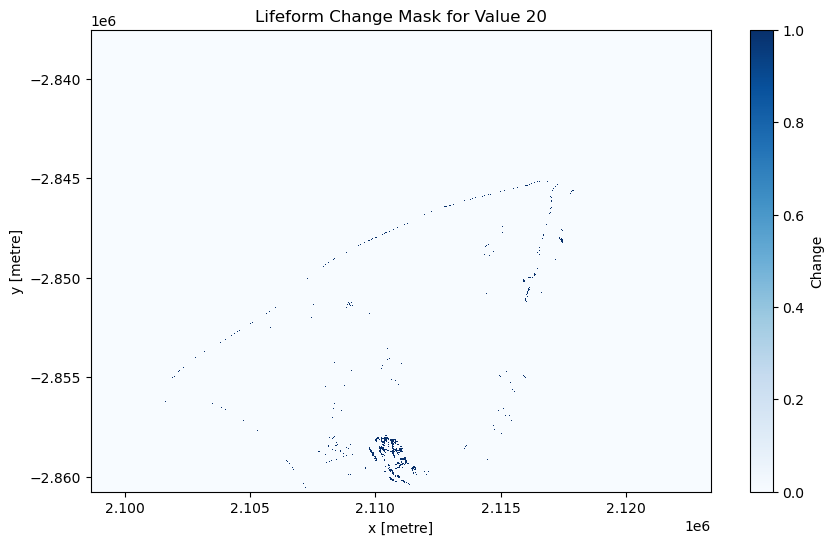

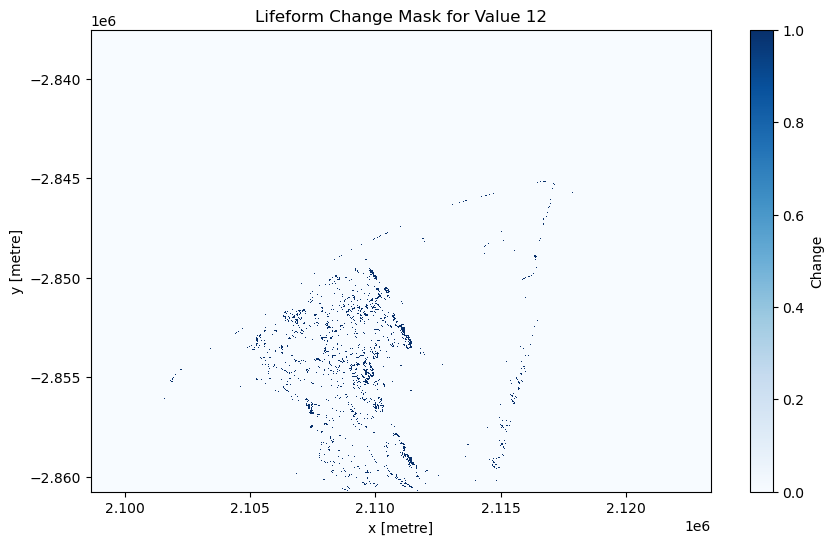

In [12]:
# Ensure actual data loading is in place of random data

# Load actual data for level3 and lifeform changes
start_l3 = lc.level3[0].astype(np.int32)
end_l3 = lc.level3[-1].astype(np.int32)
ignore_no_change = False
change_vals_l3 = (start_l3 * 1000) + end_l3
if ignore_no_change:
    change_vals_l3 = np.where(start_l3 == end_l3, 0, change_vals_l3)
level_3 = lc.level3[0].drop_vars("time")

obs_change_l3_2010_2020 = xr.DataArray(
    data=change_vals_l3,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)
obs_change_l3 = obs_change_l3_2010_2020.to_dataset(name="l3_2010_2020")
del obs_change_l3_2010_2020

# Load actual data for lifeform changes
start_lf = lc.lifeform[0].astype(np.int32)
end_lf = lc.lifeform[-1].astype(np.int32)
change_vals_lf = (start_lf * 10) + end_lf
if ignore_no_change:
    change_vals_lf = np.where(start_lf == end_lf, 0, change_vals_lf)
lifeform = lc.lifeform[0].drop_vars("time")

obs_change_lf_2010_2020 = xr.DataArray(
    data=change_vals_lf,
    coords=lifeform.coords,
    dims=lifeform.dims,
    name="observed change",
    attrs=lifeform.attrs,
    fastpath=False,
)
obs_change_lf = obs_change_lf_2010_2020.to_dataset(name="lf_2010_2020")
del obs_change_lf_2010_2020

# Define selected values (example values, replace with actual user inputs)
selected_level3_values = [111111, 112112]  # Example values
selected_lifeform_values = [10, 20, 12]    # Example values

# Function to create and display individual masks
def create_and_display_individual_masks():
    global selected_level3_values, selected_lifeform_values

    # Debug: Print selected values
    print(f"Selected Level3 Values: {selected_level3_values}")
    print(f"Selected Lifeform Values: {selected_lifeform_values}")

    if selected_level3_values:
        # Create and plot individual masks for each Level3 value
        for lvl3_val in selected_level3_values:
            change_l3 = np.where(
                (obs_change_l3.l3_2010_2020 == lvl3_val),
                1,
                0
            )

            change_xr_l3 = xr.DataArray(
                data=change_l3,
                coords=obs_change_l3.coords,
                dims=obs_change_l3.dims,
                name="Change",
                attrs=None
            )

            change_ds_l3 = change_xr_l3.to_dataset(name="Change")
            
            # Plot the results
            fig, ax = plt.subplots(figsize=(10, 6))
            change_ds_l3.Change.plot(ax=ax, cmap='Reds')
            ax.set_title(f"Level3 Change Mask for Value {lvl3_val}")
            plt.show()
    
    if selected_lifeform_values:
        # Create and plot individual masks for each Lifeform value
        for lf_val in selected_lifeform_values:
            change_lf = np.where(
                (obs_change_lf.lf_2010_2020 == lf_val),
                1,
                0
            )

            change_xr_lf = xr.DataArray(
                data=change_lf,
                coords=obs_change_lf.coords,
                dims=obs_change_lf.dims,
                name="Change",
                attrs=None
            )

            change_ds_lf = change_xr_lf.to_dataset(name="Change")
            
            # Plot the results
            fig, ax = plt.subplots(figsize=(10, 6))
            change_ds_lf.Change.plot(ax=ax, cmap='Blues')
            ax.set_title(f"Lifeform Change Mask for Value {lf_val}")
            plt.show()

# Call the function to create and display the masks
create_and_display_individual_masks()
